In [ ]:
!pip install numpy


In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
%cd gdrive/MyDrive/IA 2023

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/IA 2023'
/content/gdrive/MyDrive/IA 2023


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random


        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

In [ ]:
def subtractive_clustering(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb == 0:
        Rb = Ra * 1.15

    n_samples, n_features = data.shape
    centers = []  # Lista para almacenar los centros de los clústeres
    labels = np.zeros(n_samples, dtype=int)  # Etiquetas de clúster para cada punto

    # Escala los datos a un rango específico (por ejemplo, [0, 1])
    data_normalized = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

    # Calcula la matriz de distancias euclidianas
    dist_matrix = np.linalg.norm(data_normalized[:, np.newaxis, :] - data_normalized, axis=2)

    # Calcula P, la influencia de cada punto como centro
    alpha = (Ra / 2) ** 2
    P = np.sum(np.exp(-dist_matrix ** 2 / alpha), axis=0)

    # Encuentra el punto con la máxima influencia
    i_max = np.argmax(P)
    C = data_normalized[i_max]
    p = P[i_max]
    centers.append(C)

    # Inicia el proceso de sustracción iterativa
    continue_subtraction = True
    subtract_P = True

    while continue_subtraction:
        p_prev = p
        if subtract_P:
            P -= p * np.exp(-np.linalg.norm(data_normalized - C, axis=1) ** 2 / (Rb / 2) ** 2)
        subtract_P = True
        i_max = np.argmax(P)
        C = data_normalized[i_max]
        p = P[i_max]

        if p > AcceptRatio * p_prev:
            centers.append(C)
        elif p < RejectRatio * p_prev:
            continue_subtraction = False
        else:
            d_ratio = np.min([np.linalg.norm(C - c) for c in centers])
            if d_ratio / Ra + p / p_prev >= 1:
                centers.append(C)
            else:
                P[i_max] = 0
                subtract_P = False

        if not any(P > 0):
            continue_subtraction = False

    # Asigna etiquetas de clúster a cada punto
    for i, point in enumerate(data_normalized):
        distances_to_centers = [np.linalg.norm(point - center) for center in centers]
        labels[i] = np.argmin(distances_to_centers)

    # Convierte los centros de clúster de nuevo al rango original
    centers_original_range = centers * (np.max(data, axis=0) - np.min(data, axis=0)) + np.min(data, axis=0)

    return labels, centers_original_range


In [ ]:
def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        self.mse = float()

    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subtractive_clustering(data, radii)

        #print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center

        self.mse = self.entrenar(data)  # Llama a la función de entrenamiento

    def entrenar(self, data):
        P = data[:,:-1]  # Extrae las variables de entrada desde el conjunto de datos
        T = data[:,-1]   # Extrae la variable de salida deseada desde el conjunto de datos

        # Calcula los valores sigma para las funciones de membresía de entrada
        sigma = np.array([(i.maxValue - i.minValue) / np.sqrt(8) for i in self.inputs])

        # Calcula los niveles de activación para cada regla y entrada utilizando las funciones de membresía gaussiana definidas en gaussmf
        f = [np.prod(gaussmf(P, cluster, sigma), axis=1) for cluster in self.rules]

        # Transpone la matriz de niveles de activación para que las reglas sean las filas y las instancias de datos sean las columnas
        nivel_acti = np.array(f).T

        # Calcula la suma de los niveles de activación para cada instancia de datos
        sumMu = np.vstack(np.sum(nivel_acti, axis=1))

        # Agrega una columna de unos al conjunto de datos de entrada
        P = np.c_[P, np.ones(len(P))]

        # Obtiene el número de variables de entrada después de agregar la columna de unos
        n_vars = P.shape[1]

        # Crea un patrón de orden para reorganizar las columnas de entrada
        orden = np.tile(np.arange(0, n_vars), len(self.rules))

        # Repite los niveles de activación para las nuevas columnas de entrada
        acti = np.tile(nivel_acti, [1, n_vars])
        inp = P[:, orden]

        # Calcula la matriz A utilizada en el sistema de ecuaciones lineales
        A = acti * inp / sumMu

        # Define el vector de resultados (valores de salida deseada)
        b = T

        # Resuelve el sistema de ecuaciones lineales utilizando mínimos cuadrados
        solutions, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

        # Almacena las soluciones (coeficientes) en el objeto FIS
        self.solutions = solutions

        # Calcula el Error Cuadrático Medio (MSE) para evaluar el rendimiento del modelo entrenado
        mse = np.mean((np.dot(A, solutions) - b) ** 2)

        # Devuelve el valor del MSE
        return mse


    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)

    def viewInputs(self):
        for input in self.inputs:
            input.view()

    def getMse(self):
      return self.mse



In [ ]:
def normalizacion(data,min_val = 0,max_val = 1):
    data_min = min(data)
    data_max = max(data)

    # Normaliza los datos al rango [min, max]
    normalized_data = [min_val + ((max_val - min_val) * ((x - data_min) / (data_max - data_min))) for x in data]

    return normalized_data

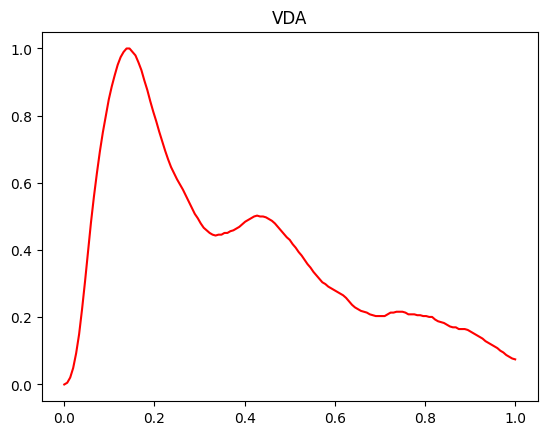

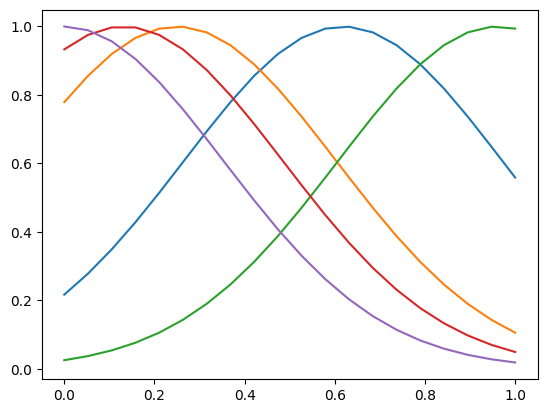

In [ ]:
filename = "/content/gdrive/MyDrive/IA 2023/VDA/samplesVDA3.txt"
x_vda = []
x_tiempo = []
i = 0.0
with open(filename) as f:
  for lines in f:
    x_vda.append(int(lines))
    x_tiempo.append(0.0025 * i)
    i += 1

#Normalizacion de datos
x_vda = normalizacion(x_vda)
x_tiempo = normalizacion(x_tiempo)

#Convierto a array de numpy los datos
x_vda = np.array(x_vda)
x_tiempo = np.array(x_tiempo)

#Grafico los datos
plt.figure()
# print(len(x_vda))
plt.plot(x_tiempo,x_vda,color = "red")
plt.title("VDA")
plt.show()

data = np.vstack((x_tiempo, x_vda)).T

#Entrenamiento del modelo
model = fis()
mseList = []

for i in range(500): #mejor fit en 80 repeticiones
  radio =((i+1))/800
  model.genfis(data,radio)
  mseList.append(model.getMse())


model.viewInputs()


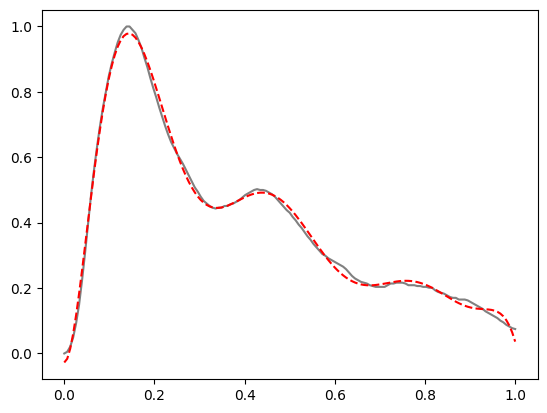

In [ ]:
r = model.evalfis(np.vstack(x_tiempo))
#print("regals ",len(fis2.rules))
plt.figure()
plt.plot(x_tiempo,x_vda,color = "grey")
plt.plot(x_tiempo,r,linestyle='--', color = "red")

[[0.61842105]
 [0.25      ]
 [0.96052632]
 [0.13157895]
 [0.        ]]


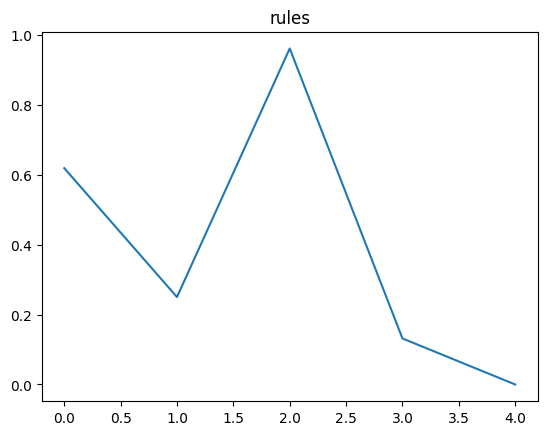

In [ ]:
rules = np.array(model.rules)
plt.figure()
plt.plot(rules)
plt.title("rules")

print(rules)

[7.11980762e-05 7.11980632e-05 7.11980533e-05 7.11980240e-05
 7.11980515e-05 7.11980095e-05 7.11980883e-05 7.11980777e-05
 7.11980488e-05 7.11980244e-05 7.11980892e-05 7.11922127e-05
 7.11796165e-05 7.11872664e-05 7.11842042e-05 7.11684391e-05
 7.11845230e-05 7.11830424e-05 7.11837708e-05 7.11730201e-05
 7.11550808e-05 7.11436944e-05 7.11434692e-05 7.11466110e-05
 7.11357921e-05 7.11294303e-05 7.11220003e-05 7.11185617e-05
 7.11315731e-05 7.11214054e-05 7.10997301e-05 7.11114864e-05
 7.11213265e-05 7.11373406e-05 7.11457996e-05 7.11378971e-05
 7.11338672e-05 7.11438006e-05 7.11410481e-05 7.11448109e-05
 7.11381513e-05 7.11399684e-05 7.11189982e-05 7.11351997e-05
 7.11077975e-05 7.11183387e-05 7.11332375e-05 7.11225064e-05
 7.11232576e-05 7.11229988e-05 7.11248326e-05 7.11370022e-05
 7.11212597e-05 7.11275988e-05 7.11250865e-05 7.11176450e-05
 7.11009130e-05 7.10928707e-05 7.10951654e-05 7.10936704e-05
 7.10801031e-05 7.10633774e-05 7.10763833e-05 7.10622325e-05
 7.10623595e-05 7.109525

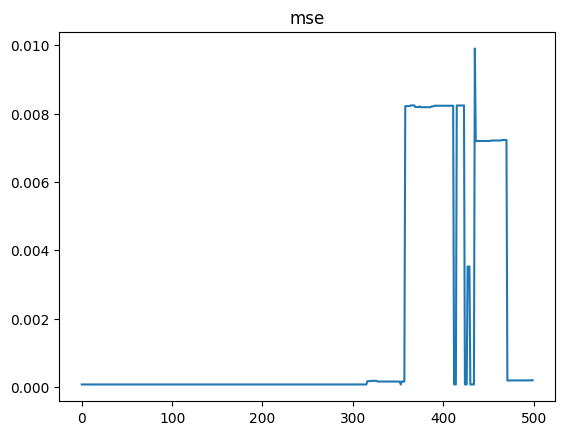

In [ ]:
mseList = np.array(mseList)
plt.figure()
plt.plot(mseList)
plt.title("mse")

print(mseList)
#Al llegar a 20 - 25 repeticiones de entrenamiento el error se dispara ¿por qué?
print("=====Mediana de MSE=========")
print(np.sum(mseList) / float(len(mseList)))

[0.000e+00 1.000e-04 2.000e-04 ... 9.998e-01 9.999e-01 1.000e+00]


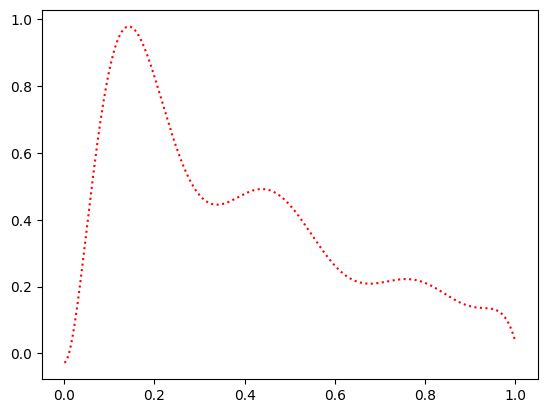

In [ ]:
#Prediccion de vda segun tiempo
paso = 0.0001
x_tiempoReg = [i * paso for i in range(int(1 / paso) + 1)]
x_tiempoReg = np.array(x_tiempoReg)
print(x_tiempoReg)
prediccion = model.evalfis(np.vstack(x_tiempoReg))

#plt.plot(x_tiempo,x_vda,color = "grey")
plt.plot(x_tiempoReg,prediccion,linestyle='dotted', color = "red")
